In [1]:
import os

In [2]:
live_training_dir = 'data/train/live'
spoof_training_dir = 'data/train/spoof'


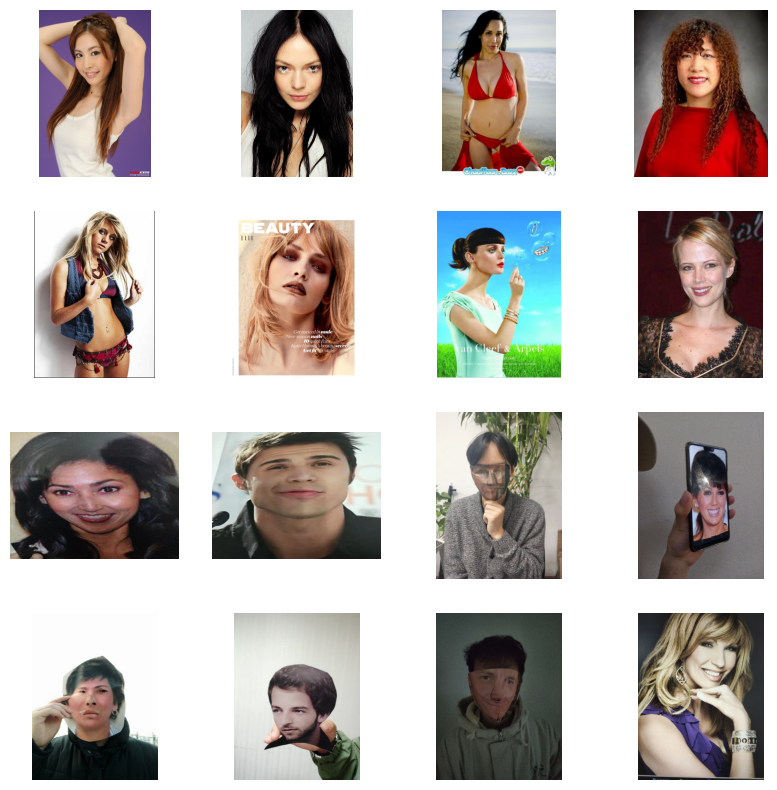

In [3]:


import matplotlib.pyplot as plt
import numpy as np
import cv2

from IPython.core.pylabtools import figsize

samples_dog = [os.path.join(live_training_dir,np.random.choice(os.listdir(live_training_dir),1)[0]) for _ in range(8)]
samples_cat = [os.path.join(spoof_training_dir,np.random.choice(os.listdir(spoof_training_dir),1)[0]) for _ in range(8)]

nrows = 4
ncols = 4

fig, ax = plt.subplots(nrows,ncols,figsize = (10,10))
ax = ax.flatten()

for i in range(nrows*ncols):
  if i < 8:
    pic = plt.imread(samples_dog[i%8])
    ax[i].imshow(pic)
    ax[i].set_axis_off()
  else:
    pic = plt.imread(samples_cat[i%8])
    ax[i].imshow(pic)
    ax[i].set_axis_off()
plt.show()

In [4]:

import torch
import torchvision
from torchvision import datasets, transforms

train_dir = "data/train"
test_dir = "data/test"

#transformations
train_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.ToTensor(),                                
                                       torchvision.transforms.Normalize(
                                           mean=[0.485, 0.456, 0.406],
                                           std=[0.229, 0.224, 0.225],
    ),
                                       ])
test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      torchvision.transforms.Normalize(
                                          mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.225],
    ),
                                      ])

#datasets
train_data = datasets.ImageFolder(train_dir,transform=train_transforms)
test_data = datasets.ImageFolder(test_dir,transform=test_transforms)

#dataloader
train_loader = torch.utils.data.DataLoader(train_data, shuffle = True, batch_size=16)
test_loader = torch.utils.data.DataLoader(test_data, shuffle = True, batch_size=16)

In [5]:
def make_train_step(model, optimizer, loss_fn):
  def train_step(x,y):
    #make prediction
    yhat = model(x)
    #enter train mode
    model.train()
    #compute loss
    loss = loss_fn(yhat,y)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    #optimizer.cleargrads()

    return loss
  return train_step

In [6]:

from torchvision import datasets, models, transforms
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"
model = models.resnet18(pretrained=True)

#freeze all params
for params in model.parameters():
  params.requires_grad_ = False

#add a new final layer
nr_filters = model.fc.in_features  #number of input features of last layer
model.fc = nn.Linear(nr_filters, 1)

model = model.to(device)

c:\Users\PLour\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\PLour\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:

from torch.nn.modules.loss import BCEWithLogitsLoss
from torch.optim import lr_scheduler

#loss
loss_fn = BCEWithLogitsLoss() #binary cross entropy with sigmoid, so no need to use sigmoid in the model

#optimizer
optimizer = torch.optim.Adam(model.fc.parameters()) 

#train step
train_step = make_train_step(model, optimizer, loss_fn)

In [8]:
#%%capture
!pip install tqdm
from tqdm import tqdm


losses = []
val_losses = []

epoch_train_losses = []
epoch_test_losses = []

n_epochs = 10
early_stopping_tolerance = 3
early_stopping_threshold = 0.03

for epoch in range(n_epochs):
  epoch_loss = 0
  for i ,data in tqdm(enumerate(train_loader), total = len(train_loader)): #iterate ove batches
    x_batch , y_batch = data
    x_batch = x_batch.to(device) #move to gpu
    y_batch = y_batch.unsqueeze(1).float() #convert target to same nn output shape
    y_batch = y_batch.to(device) #move to gpu


    loss = train_step(x_batch, y_batch)
    epoch_loss += loss/len(train_loader)
    losses.append(loss)
    
  epoch_train_losses.append(epoch_loss)
  print('\nEpoch : {}, train loss : {}'.format(epoch+1,epoch_loss))

  #validation doesnt requires gradient
  with torch.no_grad():
    cum_loss = 0
    for x_batch, y_batch in test_loader:
      x_batch = x_batch.to(device)
      y_batch = y_batch.unsqueeze(1).float() #convert target to same nn output shape
      y_batch = y_batch.to(device)

      #model to eval mode
      model.eval()

      yhat = model(x_batch)
      val_loss = loss_fn(yhat,y_batch)
      cum_loss += loss/len(test_loader)
      val_losses.append(val_loss.item())


    epoch_test_losses.append(cum_loss)
    print('Epoch : {}, val loss : {}'.format(epoch+1,cum_loss))  
    
    best_loss = min(epoch_test_losses)
    
    #save best model
    if cum_loss <= best_loss:
      best_model_wts = model.state_dict()
    
    #early stopping
    early_stopping_counter = 0
    if cum_loss > best_loss:
      early_stopping_counter +=1

    if (early_stopping_counter == early_stopping_tolerance) or (best_loss <= early_stopping_threshold):
      print("/nTerminating: early stopping")
      break #terminate training
    
#load best model
model.load_state_dict(best_model_wts)

100%|██████████| 1218/1218 [3:01:31<00:00,  8.94s/it] 



Epoch : 1, train loss : 0.2632649838924408
Epoch : 1, val loss : 0.05621254816651344


100%|██████████| 1218/1218 [3:06:31<00:00,  9.19s/it] 



Epoch : 2, train loss : 0.20234353840351105
Epoch : 2, val loss : 0.15660235285758972


100%|██████████| 1218/1218 [49:10<00:00,  2.42s/it]



Epoch : 3, train loss : 0.1904473602771759
Epoch : 3, val loss : 0.10101643949747086


100%|██████████| 1218/1218 [49:57<00:00,  2.46s/it]



Epoch : 4, train loss : 0.1848047971725464
Epoch : 4, val loss : 0.1881934255361557


100%|██████████| 1218/1218 [50:18<00:00,  2.48s/it]



Epoch : 5, train loss : 0.1807793825864792
Epoch : 5, val loss : 0.0787138044834137


100%|██████████| 1218/1218 [53:10<00:00,  2.62s/it]



Epoch : 6, train loss : 0.17725172638893127
Epoch : 6, val loss : 0.031545910984277725


100%|██████████| 1218/1218 [54:19<00:00,  2.68s/it]



Epoch : 7, train loss : 0.17598704993724823
Epoch : 7, val loss : 0.05594814568758011


100%|██████████| 1218/1218 [51:08<00:00,  2.52s/it]



Epoch : 8, train loss : 0.17462697625160217
Epoch : 8, val loss : 0.1428939402103424


100%|██████████| 1218/1218 [51:42<00:00,  2.55s/it]


Epoch : 9, train loss : 0.1730843484401703


Epoch : 9, val loss : 0.07989679276943207


100%|██████████| 1218/1218 [50:20<00:00,  2.48s/it]



Epoch : 10, train loss : 0.17414142191410065
Epoch : 10, val loss : 0.029753580689430237
/nTerminating: early stopping


<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction : spoof


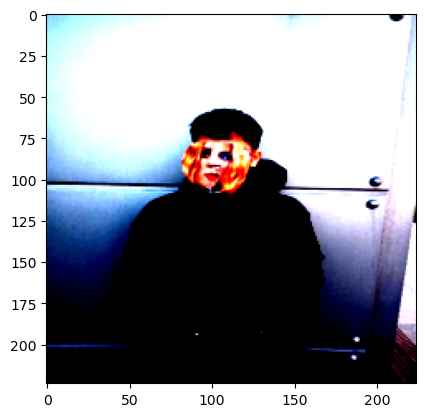

In [42]:
import matplotlib.pyplot as plt 

def inference(test_data):
  idx = torch.randint(1, len(test_data), (1,))
  sample = torch.unsqueeze(test_data[idx][0], dim=0).to(device)

  
  if torch.sigmoid(model(sample)) < 0.5:
    print("Prediction : live")
  else:
    print("Prediction : spoof")


  plt.imshow(test_data[idx][0].permute(1, 2, 0))

inference(test_data)

In [43]:
model.eval()  # Set the model to evaluation mode

total_loss = 0
total_correct = 0
total_samples = 0

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.unsqueeze(1).float().to(device)  # Reshape target to match model output

        yhat = model(x_batch)  # Perform forward pass
        loss = loss_fn(yhat, y_batch)  # Calculate loss

        total_loss += loss.item() * x_batch.size(0)  # Accumulate loss

        total_correct += ((yhat.sigmoid() > 0.5) ==  (y_batch > 0.5)).sum().item()  # Count correct predictions
        total_samples += x_batch.size(0)  # Count total samples

avg_loss = total_loss / total_samples
accuracy = total_correct / total_samples

print('Evaluation loss: {:.4f}, Accuracy: {:.4f}'.format(avg_loss, accuracy))

Evaluation loss: 0.1334, Accuracy: 0.9542


In [47]:
torch.save(model, 'models/transfer_learning.pt')

In [48]:

model = torch.load('models/transfer_learning.pt')
model.eval()

AttributeError: 'collections.OrderedDict' object has no attribute 'eval'

In [46]:
model

OrderedDict([('conv1.weight',
              tensor([[[[-1.0419e-02, -6.1356e-03, -1.8098e-03,  ...,  5.6615e-02,
                          1.7083e-02, -1.2694e-02],
                        [ 1.1083e-02,  9.5276e-03, -1.0993e-01,  ..., -2.7124e-01,
                         -1.2907e-01,  3.7424e-03],
                        [-6.9434e-03,  5.9089e-02,  2.9548e-01,  ...,  5.1972e-01,
                          2.5632e-01,  6.3573e-02],
                        ...,
                        [-2.7535e-02,  1.6045e-02,  7.2595e-02,  ..., -3.3285e-01,
                         -4.2058e-01, -2.5781e-01],
                        [ 3.0613e-02,  4.0960e-02,  6.2850e-02,  ...,  4.1384e-01,
                          3.9359e-01,  1.6606e-01],
                        [-1.3736e-02, -3.6746e-03, -2.4084e-02,  ..., -1.5070e-01,
                         -8.2230e-02, -5.7828e-03]],
              
                       [[-1.1397e-02, -2.6619e-02, -3.4641e-02,  ...,  3.2521e-02,
                          6.6221